In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import heapq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

from utils import latexify

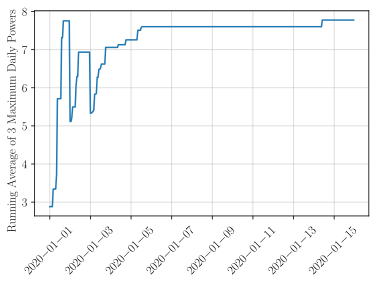

In [50]:
def is_new_month(prev_datetime, current_datetime):
    return prev_datetime.month != current_datetime.month or prev_datetime.year != current_datetime.year

def update_daily_max_power(daily_max_power, datetime, power):
    day = datetime.date()
    daily_max_power[day] = max(daily_max_power[day], power)

def compute_average_N_largest(daily_max_power, N):
    min_heap = []

    for day, max_power in daily_max_power.items():
        if len(min_heap) < N:
            heapq.heappush(min_heap, max_power)
        else:
            if max_power > min_heap[0]:
                heapq.heappushpop(min_heap, max_power)
    
    num_days = min(N, len(min_heap))
    return sum(min_heap) / num_days if num_days > 0 else 0

load_data = pd.read_pickle("data/load_data.pickle")

start_date = load_data.index[0]
end_date = start_date + pd.Timedelta(days=15, unit='D')
sliced_data = load_data.loc[(load_data.index >= start_date) & (load_data.index < end_date)]

N = 3
daily_max_power = defaultdict(float)
running_averages = []

prev_datetime = sliced_data.index[0]

for datetime, power in sliced_data.items():
    if is_new_month(prev_datetime, datetime):
        daily_max_power = defaultdict(float)

    update_daily_max_power(daily_max_power, datetime, power)
    current_average = compute_average_N_largest(daily_max_power, N)
    running_averages.append(current_average)

    prev_datetime = datetime

plt.figure()
plt.plot(sliced_data.index, running_averages)
plt.ylabel('Running Average of 3 Maximum Daily Powers')
plt.xticks(rotation=45)
plt.show()


In [63]:
import cvxpy as cp

def is_new_month(prev_datetime, current_datetime):
    return prev_datetime.month != current_datetime.month or prev_datetime.year != current_datetime.year

def compute_average_N_largest(power_month, N):
    daily_max_powers = []

    # Group datetimes by day
    grouped_datetimes = defaultdict(list)
    for datetime, power in power_month.items():
        grouped_datetimes[datetime.date()].append(power)

    # Compute the maximum power for each day
    for powers in grouped_datetimes.values():
        daily_max = cp.max(cp.hstack(powers))
        daily_max_powers.append(daily_max)

    # Compute the average of the largest N daily powers
    num_days = len(daily_max_powers)
    z = cp.sum_largest(cp.hstack(daily_max_powers), min(N, num_days)) / min(N, num_days)
    return z

load_data = pd.read_pickle("data/load_data.pickle")
start_date = load_data.index[0]
end_date = start_date + pd.Timedelta(days=1, unit='D')
sliced_data = load_data.loc[(load_data.index >= start_date) & (load_data.index < end_date)]

N = 3
power_curr_month = defaultdict(float)

# Add values to dicitonary
for datetime, power in sliced_data.items():
    power_curr_month[datetime] = power

# Get next datetimes
last_key = max(power_curr_month.keys())
next_datetime = last_key + pd.Timedelta(hours=1)
datetimes = pd.date_range(start=next_datetime, periods=24*5, freq='H')
powers = cp.Variable(24*5)
powers.value = load_data.loc[load_data.index.isin(datetimes)].values

new_entries = dict(zip(datetimes, powers))
power_curr_month.update(new_entries)
    
# Compute the average of the largest N daily powers as a cvxpy expresion from power_curr_month
z = compute_average_N_largest(power_curr_month, N)

print(z.value)

7.602666666666667
